## Unsupervised Deep Learning for usage behavior

Irrespective of the churn prediction, we would like to find which are the main patterns that can be recognized by a network. Those patterns can be used to understand the segments or groups in your population based on usage behavior.
We tried a few approaches:

- Fully connected autoencoders
- Fully connected autoencoder with tied weights
- Convolutional autoencoders

For each approach, we are trying to visualize what are the patterns represented by the network especially at the autoencoder bottleneck and we are trying to understand what maximizes the activation of the intermediate layer.


References: 

Churn analysis using convolutional network and autoencoders https://arxiv.org/abs/1604.05377

https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html

https://blog.keras.io/building-autoencoders-in-keras.html

## 0. Pre-requisites

In [1]:
from keras import backend as K
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers import Input, concatenate, BatchNormalization
from keras.models import Model
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D 
from keras.optimizers import SGD, RMSprop
from keras.utils import np_utils                                                                                                      
from keras.models import Sequential 


from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pylab as pl
import numpy as np
import math
import pandas as pd
from sklearn import metrics
from sklearn.manifold import TSNE
from mpl_toolkits.axes_grid1 import AxesGrid

import tensorflow as tf

%matplotlib inline

Using TensorFlow backend.


All the data is provided in a single table that is build around daily usage for a full month per subscriber. The 12 fields from #outgoing calls to Cost represents daily aggregate for 31 days (one line per SUBSCRIBER_ID and Date) prior a churn assessment window of one month. This assessed churn is given in the CHURN column and is repeated 31 times of each subscriber only for convenience.

The plan characteristic is the latest plan of each subscriber and is repeated 31 times only for table convenience.

In [2]:
# The code was removed by DSX for sharing.

In [3]:
from io import StringIO
import requests
import json

# This function accesses a file in your Object Storage. The definition contains your credentials.
# You might want to remove those credentials before you share your notebook.
def get_object_storage_file_with_credentials_8f8071a3ce1746d89c1630604ac3201f(container, filename):
    """This functions returns a StringIO object containing
    the file content from Bluemix Object Storage."""

    url1 = ''.join([credentials_1['auth_url'], '/v3/auth/tokens'])
    data = {'auth': {'identity': {'methods': ['password'],
            'password': {'user': {'name': credentials_1['username'],'domain': {'id': credentials_1['domain_id']},
            'password': credentials_1['password']}}}}}
    headers1 = {'Content-Type': 'application/json'}
    resp1 = requests.post(url=url1, data=json.dumps(data), headers=headers1)
    resp1_body = resp1.json()
    for e1 in resp1_body['token']['catalog']:
        if(e1['type']=='object-store'):
            for e2 in e1['endpoints']:
                        if(e2['interface']=='public'and e2['region']=='dallas'):
                            url2 = ''.join([e2['url'],'/', container, '/', filename])
    s_subject_token = resp1.headers['x-subject-token']
    headers2 = {'X-Auth-Token': s_subject_token, 'accept': 'application/json'}
    resp2 = requests.get(url=url2, headers=headers2)
    return StringIO(resp2.text)

X_train = pd.read_csv(get_object_storage_file_with_credentials_8f8071a3ce1746d89c1630604ac3201f('DeepLearningforBusiness', 'usage_data_train.csv'))
X_test = pd.read_csv(get_object_storage_file_with_credentials_8f8071a3ce1746d89c1630604ac3201f('DeepLearningforBusiness', 'usage_data_test.csv'))
X_test.head()

,SUBSCRIBER_ID,Date,CHURN_FLAG,Plan,# outgoing calls _normalized,# incoming calls _normalized,Sum duration incoming calls _normalized,Sum duration outgoing calls _normalized,Volume voice_normalized,Volume upload _normalized,Volume download_normalized,Duration data connection _normalized,# data connection _normalized,# MT SMS _normalized,# MO SMS _normalized,Cost_normalized
0,anon_S10001,2014-08-26,0,1,0.0,0.0,0.581818,0.0,0.0,0.0,0.0,0.265292,0.0,0.0,0.090670,0.0
1,anon_S10001,2014-08-27,0,1,0.0,0.0,0.290909,0.0,0.0,0.0,0.0,0.205503,0.0,0.0,0.106000,0.0
2,anon_S10001,2014-08-28,0,1,0.0,0.0,0.290909,0.0,0.0,0.0,0.0,0.305964,0.0,0.0,0.138628,0.0
3,anon_S10001,2014-08-29,0,1,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.658406,0.0,0.0,0.510277,0.0
4,anon_S10001,2014-08-30,0,1,0.0,0.0,0.254545,0.0,0.0,0.0,0.0,0.576213,0.0,0.0,0.028251,0.0


As described above, the churn and the plan characteristics have only one value per subscriber. Hence, we can just aggregate through the max to obtain one row per subscriber.

In [4]:
img_rows, img_cols = 31, 12

X_train = X_train.ix[:,4:16].values
#Y_train = Y_train.ix[:,0:1].values
X_test = X_test.ix[:,4:16].values
#Y_test = Y_test.ix[:,0:1].values

print('X_train shape:', X_train.shape)                                                      
print(X_train.shape[0], 'train days')                                                    
print(X_test.shape[0], 'test days') 

X_train = X_train.reshape(-1, img_rows, img_cols, 1)                          
X_test = X_test.reshape(-1, img_rows, img_cols, 1)                             
X_train = X_train.astype('float32')                                                         
X_test = X_test.astype('float32')                                                                                                                                  

print('X_train shape:', X_train.shape)                                                      
print(X_train.shape[0], 'train images')                                                    
print(X_test.shape[0], 'test images')  

#Y_train = np_utils.to_categorical(Y_train, 2)                                      
#Y_test = np_utils.to_categorical(Y_test, 2) 
#print(Y_train.shape[0], 'train target images')                                                    
#print(Y_test.shape[0], 'test target images')

X_train shape: (298096, 12)
298096 train days
130262 test days
X_train shape: (9616, 31, 12, 1)
9616 train images
4202 test images


## 1. Fully connected autoencoder
In order to get very simple segments of usage behavior, we first use a simple fully connected autoencoder and we later check with the pictures how well it performs.

First we look at plain autoencoder i.e. two dense layers of transposed size.

(9616, 31, 12)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 31, 12)            0         
_________________________________________________________________
batchnorm_usage (BatchNormal (None, 31, 12)            48        
_________________________________________________________________
flatten_12 (Flatten)         (None, 372)               0         
_________________________________________________________________
encoded (Dense)              (None, 5)                 1865      
_________________________________________________________________
decoded (Dense)              (None, 372)               2232      
_________________________________________________________________
decoded_reshape (Reshape)    (None, 31, 12)            0         
Total params: 4,145
Trainable params: 4,121
Non-trainable params: 24
__________________________________________________________

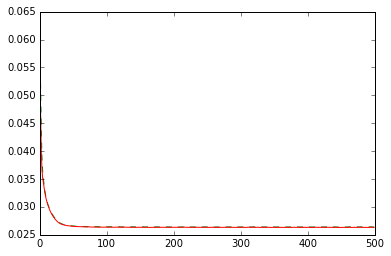

In [64]:
X_train_encoder = X_train.reshape(-1,31,12)                           
X_test_encoder = X_test.reshape(-1,31,12)

print(X_train_encoder.shape)

input_img =  Input(shape=(31,12), name = "input_img")
x1 = BatchNormalization(axis=2,name="batchnorm_usage")(input_img)
x1 = Flatten()(x1)
encoded = Dense(5,activation='relu',name = "encoded")(x1)
x1 = Dense(31*12,activation = 'linear', name = "decoded")(encoded)
decoded = Reshape((31,12), name = "decoded_reshape")(x1)

autoencoder = Model(input_img, decoded)
autoencoder.summary()


autoencoder.compile(loss='mean_squared_error', optimizer='adadelta')
my_model = autoencoder.fit(X_train_encoder, X_train_encoder, epochs = 500, batch_size=128, verbose = False, shuffle=True, validation_data=(X_test_encoder, X_test_encoder))

plt.plot(my_model.epoch, my_model.history['loss'], 'g--')
plt.plot(my_model.epoch, my_model.history['val_loss'], 'r-')

It is interesting to look if the decoder is able to reconstruct the image after the bottleneck of the Dense layer. We see that with a simple fully connected layer, the reconstruction is far from perfect. However the main patterns are learnt. One interesting observation is that as soons as the network seens an observation in one of the columns, it assumes that it is true for almost the whole 31 days period. So in a way the temporal pattern are not fully captured.

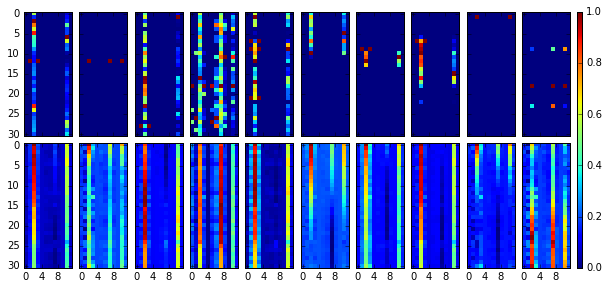

In [65]:
decoded_imgs = autoencoder.predict(X_test_encoder)

X = np.zeros((20,31,12))

for i in range(10):
    X[i,:,:] = X_test[260+i].reshape(31, 12)
    X[i+10,:,:] = decoded_imgs[260+i].reshape(31, 12)
  
fig = plt.figure(1, (10, 10))
grid = AxesGrid(fig, 111, nrows_ncols=(2, 10), axes_pad=0.1, cbar_mode = 'single')

for i in range(20):
    im = grid[i].imshow(X[i,:,:],interpolation='nearest',cmap=None)
    grid.cbar_axes[i].colorbar(im)
    grid[i].set_xticks(np.arange(0, 12, 4))    

plt.show()

In order to understand what are the typical profile, we can look at which profiles/pattern are captured in the intermediate layer. In other words we are looking at which pictures are maximizing the activation of the hidden layer of the network. In the case of the fully connected network, the input pixels are given by formula which we can find http://deeplearning.stanford.edu/wiki/index.php/Visualizing_a_Trained_Autoencoder

We first look at what maximizes the activation of the bottleneck

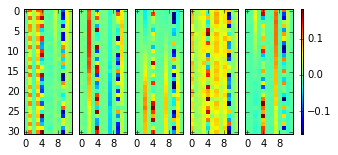

In [66]:
layer = autoencoder.get_layer("encoded")
W = np.transpose(layer.get_weights()[0])

adj_W = np.zeros(W.shape) 
for i in range(0,5):
    sqr_ss = np.sqrt(np.sum(W[i,:]*W[i,:])) 
    for j in range(0,31*12-1):
        adj_W[i,j] = (W[i,j])/sqr_ss

adj_W = adj_W.reshape(5,31,12)
fig = plt.figure(1, (5,5))
grid = AxesGrid(fig, 111, nrows_ncols=(1, 5), axes_pad=0.1, cbar_mode = 'single')
for i in range(5):
    im = grid[i].imshow(adj_W[i,:,:],interpolation='nearest',cmap=None)
    grid.cbar_axes[i].colorbar(im)
    grid[i].set_xticks(np.arange(0, 12, 4))    
plt.show()

We observe that different filters are coding for different columns with sometimes directions (first filter 3rd column decreasing or 5th filter 11th column increasing). However the 4 and 8th columns seems to have the same pattern for all the filters.

Now we would like to look at the other side of the hidden layer.

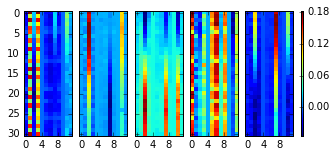

In [67]:
layer = autoencoder.get_layer("decoded")
W = layer.get_weights()[0]

adj_W = np.zeros(W.shape) 
for i in range(0,5):
    sqr_ss = np.sqrt(np.sum(W[i,:]*W[i,:])) 
    for j in range(0,31*12-1):
        adj_W[i,j] = (W[i,j])/sqr_ss

adj_W = adj_W.reshape(5,31,12)
fig = plt.figure(1, (5, 5))
grid = AxesGrid(fig, 111, nrows_ncols=(1, 5), axes_pad=0.1, cbar_mode = 'single')
for i in range(5):
    im = grid[i].imshow(adj_W[i,:,:],interpolation='nearest',cmap=None)
    grid.cbar_axes[i].colorbar(im)
    grid[i].set_xticks(np.arange(0, 12, 4))    
plt.show()

We observe clear different patterns maximizing the activation of the 5 different nodes:
- Increasing but low sum of incoming calls duration, sum of data duration and SMS incoming (except data duration high) 
- Outgoing calls, volume upload and download, # data connection
- incoming calls, outgoing calls on specific alternate day
- Decreasing and High sum of incoming calls duration, sum of data duration and SMS incoming
- Increasing then decreasing incoming calls duration and SMS incoming, very low data duration

We are finding the results we were expecting in that dimension but it remains counter-intuitive as we would like to have those results in the direction input -> hidden layer. It is mainly due to the fact that the weights in both side are not tied together. Indeed, in many application, autoencoders are forced to have the same weight matrix before and after the hidden layer (only transposed).


## 2. Fully connected autoencoder with tied weights

Below we are defining a new dense layer which is just the transpose of the previous dense layer (encoder)

In [68]:
class TiedtDense(Dense):
    def __init__(self, output_dim, master_layer, name, kernel='glorot_uniform', activation='linear',**kwargs):
        self.master_layer = master_layer
        self.output_dim = output_dim
        self.name = name
        super(TiedtDense, self).__init__(output_dim,**kwargs)
        

    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]
        self.input_dim = input_dim

        print(tf.transpose(self.master_layer.weights[0]))
        #self.W = tf.transpose(self.master_layer.weights[0])
        self.kernel = tf.transpose(self.master_layer.weights[0])
        self.bias = K.zeros((self.output_dim,))
        self.params = [self.bias]
        self.regularizers = []

Tensor("tiedt_dense_2/transpose:0", shape=(5, 372), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_13 (Flatten)         (None, 372)               0         
_________________________________________________________________
first_dense (Dense)          (None, 5)                 1865      
_________________________________________________________________
tiedt_dense_2 (TiedtDense)   (None, 372)               0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 31, 12)            0         
Total params: 1,865
Trainable params: 1,865
Non-trainable params: 0
_________________________________________________________________


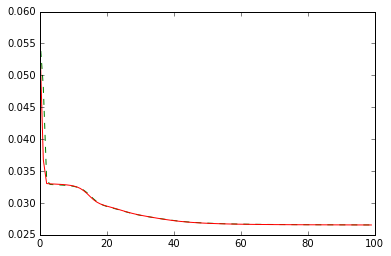

In [69]:
from keras import models

autoencoder = models.Sequential()

x1 = Flatten(input_shape = (31,12))
autoencoder.add(x1)
d =  Dense(5,activation='relu', name = "first_dense")
autoencoder.add(d)
d_t = TiedtDense(output_dim = 372, master_layer = d, name ="tied_dense")
autoencoder.add(d_t)
reshape = Reshape((31,12))
autoencoder.add(reshape)

#autoencoder = Model(input_img, decoded)
autoencoder.summary()


autoencoder.compile(loss='mean_squared_error', optimizer='adadelta')
my_model = autoencoder.fit(X_train_encoder, X_train_encoder, epochs = 100, batch_size=128, verbose = False, shuffle=True, validation_data=(X_test_encoder, X_test_encoder))

plt.plot(my_model.epoch, my_model.history['loss'], 'g--')
plt.plot(my_model.epoch, my_model.history['val_loss'], 'r-')

Let us make sure the autoencoder can actually reconstruct the input signal.

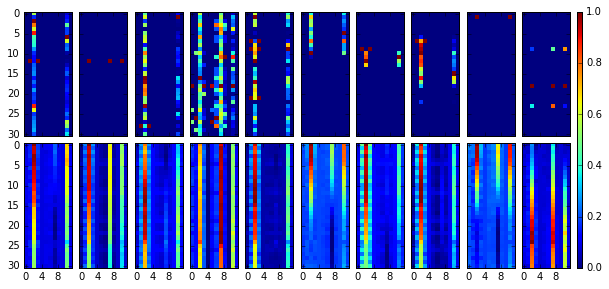

In [70]:
decoded_imgs = autoencoder.predict(X_test_encoder)

X = np.zeros((20,31,12))

for i in range(10):
    X[i,:,:] = X_test[260+i].reshape(31, 12)
    X[i+10,:,:] = decoded_imgs[260+i].reshape(31, 12)
  
fig = plt.figure(1, (10, 10))
grid = AxesGrid(fig, 111, nrows_ncols=(2, 10), axes_pad=0.1, cbar_mode = 'single')

for i in range(20):
    im = grid[i].imshow(X[i,:,:],interpolation='nearest',cmap=None)
    grid.cbar_axes[i].colorbar(im)
    grid[i].set_xticks(np.arange(0, 12, 4))    

plt.show()

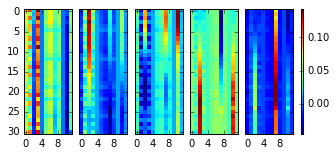

In [71]:
W = np.transpose(d.get_weights()[0])
adj_W = np.zeros(W.shape) 
for i in range(0,5):
    sqr_ss = np.sqrt(np.sum(W[i,:]*W[i,:])) 
    for j in range(0,31*12-1):
        adj_W[i,j] = (W[i,j])/sqr_ss


adj_W = adj_W.reshape(5,31,12)
fig = plt.figure(1, (5, 5))
grid = AxesGrid(fig, 111, nrows_ncols=(1, 5), axes_pad=0.1, cbar_mode = 'single')
for i in range(5):
    im = grid[i].imshow(adj_W[i,:,:],interpolation='nearest',cmap=None)
    grid.cbar_axes[i].colorbar(im)
    grid[i].set_xticks(np.arange(0, 12, 4))    
plt.show()

## 3. Convolutional autoencoder

We have seen that the simple fully connected could help us see simple patterns in the data but we also see that the decoder is not fully capable of reconstructing the behavior. Hence the need to try out more advanced type of network such as convolutional autoencoder. For this specific case and to simplify the size of the filter we would use, we are only taking the last 28 days of the picture instead of 31 days.

In [5]:
X_train_encoder = X_train[:,:28,:,:]                        
X_test_encoder = X_test[:,:28,:,:]                                                                                                                                                               

The autoencoder must be able to reconstruct the image properly while reducing the dimension significantly at the level of the bottleneck. We are using maxpooling to reduce the dimension at the encoder side and upsampling to increase the dimension at the decoder side. Hence, as opposed to our first convolutional network, the padding remains the same throughout the convolution filters.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 12, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 28, 12, 5)         40        
_________________________________________________________________
maxP1 (MaxPooling2D)         (None, 7, 12, 5)          0         
_________________________________________________________________
conv2 (Conv2D)               (None, 7, 12, 5)          305       
_________________________________________________________________
maxP2 (MaxPooling2D)         (None, 7, 3, 5)           0         
_________________________________________________________________
deconv1 (Conv2D)             (None, 7, 3, 5)           305       
_________________________________________________________________
UpS1 (UpSampling2D)          (None, 7, 12, 5)          0         
__________

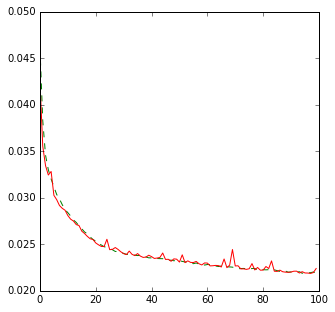

In [16]:
input_img = Input(shape=(28,12,1))
x = Convolution2D(5, (7, 1), activation='relu', padding = 'same', name = 'conv1')(input_img)
x = MaxPooling2D((4, 1), padding ='same', name = 'maxP1')(x)
x = Convolution2D(5, (1, 12), activation='relu', padding = 'same', name = 'conv2')(x)
encoded = MaxPooling2D((1, 4), padding ='same', name = 'maxP2')(x)

x = Convolution2D(5, (1, 12), activation='relu', padding = 'same', name = 'deconv1')(encoded)
x = UpSampling2D((1, 4), name = 'UpS1')(x)
x = Convolution2D(5, (7, 1), activation='relu', padding = 'same', name = 'deconv2')(x)
x = UpSampling2D((4, 1), name = 'UpS2')(x)

decoded = Convolution2D(1, (7, 12), activation='linear', padding = 'same', name = 'deconv3')(x)


autoencoder = Model(input_img, decoded)
autoencoder.summary()


autoencoder.compile(loss='mean_squared_error', optimizer='adadelta')
my_model = autoencoder.fit(X_train_encoder, X_train_encoder, epochs = 100, batch_size=128, verbose = False, shuffle=True, validation_data=(X_test_encoder, X_test_encoder))

plt.plot(my_model.epoch, my_model.history['loss'], 'g--')
plt.plot(my_model.epoch, my_model.history['val_loss'], 'r-')

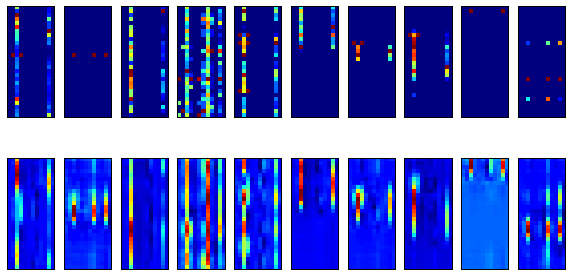

In [17]:
decoded_imgs = autoencoder.predict(X_test_encoder)

n = 10
plt.figure(figsize=(10, 5))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(X_test_encoder[260+i].reshape(28, 12),interpolation = 'nearest', cmap = None)
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i+1 + n)
    plt.imshow(decoded_imgs[260+i].reshape(28, 12),interpolation = 'nearest', cmap = None)
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

As for the fully connected autoencoder, we would like to understand what is maximizing the hidden layers, hence what are the main patterns the convolutional autoencoder is representing. In that case, there is no computed formula but we have to find the optimum with a quick gradient descent on the loss. We can then visualize the input maximizing the activation of each of the convolution filters.

In [18]:
def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    return x

In [19]:
#Choice of the layer
layer_output = autoencoder.get_layer("deconv2").output

kept_filters = []
input_img_data1 = np.random.random((1, 28, 12,1))
input_img_data = input_img_data1

for i in range(0,5):
    #input_img_data = np.zeros(28*12).reshape(1,28,12,1)  
    input_img_data = input_img_data1
    loss = K.mean(layer_output[:, :, :, i])

    # we compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]
    iterate = K.function([input_img], [loss, grads])

    step = 1

    for i in range(100):
            loss_value, grads_value = iterate([input_img_data])
            input_img_data += grads_value * step

            if loss_value <= 0.:
                # some filters get stuck to 0, we can skip them
                break


            # decode the resulting input image
    if loss_value > 0:
        print("yes")
        img = deprocess_image(input_img_data[0])
        kept_filters.append(img)

yes
yes
yes


(3, 28, 12)


IndexError: index 3 is out of bounds for axis 0 with size 3

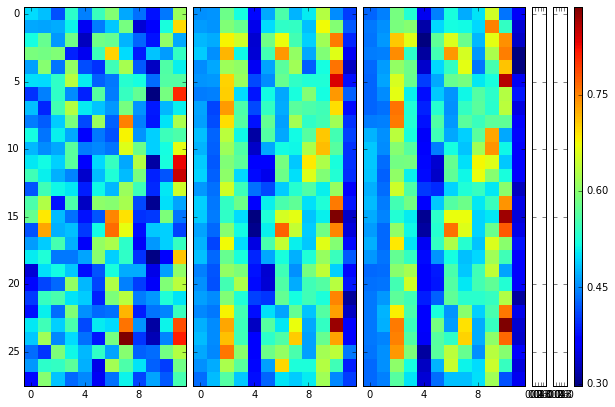

In [20]:
C1 = np.squeeze(np.array(kept_filters[0:5]))
print(C1.shape)

fig = plt.figure(1, (10, 10))
grid = AxesGrid(fig, 111, nrows_ncols=(1, 5), axes_pad=0.1, cbar_mode = 'single')
for i in range(5):
    im = grid[i].imshow(C1[i,:,:],interpolation='nearest',cmap=None)
    grid.cbar_axes[i].colorbar(im)
    grid[i].set_xticks(np.arange(0, 12, 4))    
plt.show()

### Visualize intermediate layer (bottleneck) clusters
One of the goal of autoencoder is to represent the data in a lower dimensional space which is easier to interpret or to analyze. We are taking the output of the encoder and projecting it in a 2-dimensional space with the t-SNE procedure which keeps the proximity between points. We then can visualize each pictures in the 2 dimensional space and compare that if we had done that directly on the raw data.

In [ ]:
encoder = Model(input_img,encoded)
encoded_imgs = encoder.predict(X_train_encoder)
encoded_imgs.shape
model = TSNE(n_components=2, random_state=0,perplexity = 100)
X_2d = model.fit_transform(encoded_imgs.reshape(encoded_imgs.shape[0],7*3*5))

In [11]:
np.squeeze(Y_train[:,0]).shape
#X_2d.shape
Y_train.astype(np.int64)
X_2d[:,0].shape
Y_train.astype(np.int64)[:,0].shape

NameError: name 'Y_train' is not defined

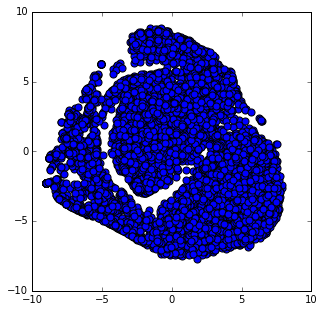

In [15]:
plt.rcParams['figure.figsize'] = 5, 5
#plt.scatter(X_2d[:,0], X_2d[:,1], s=50, c = Y_train.astype(np.int64)[:,0])
plt.scatter(X_2d[:,0], X_2d[:,1], s=50)

In [ ]:
model = TSNE(n_components=2, random_state=0,perplexity = 100)
X_2d = model.fit_transform(X_train_encoder.reshape(X_train_encoder.shape[0],28*12))

plt.rcParams['figure.figsize'] = 20, 10
plt.scatter(X_2d[:,0], X_2d[:,1], s=50, c = Y_train.astype(np.int64)[:,0])